<div align="center">
<a href="https://vbti.nl"><img src="./vbti_logo.png" width="400"></a>
</div>

# IMBD - Deep Learning

In this notebook we continue with the IMDB dataset and start building deep learning models to predict the movie score.

It contains the following sections:
 1. Converting the reviews to word embeddings, again, with the `Word2Vec` class.
 2. We will build, train and evaluate three different architectures:
  - A Multilayer perceptron, this is (as discussed in the masterclass) the most basic neural network.
  - A 1D dimensional convolutional neural network (CNN).
  - A simple recurrent neural network.
  - A LSTM.
  - A bidirectional LSTM.
    
    Al these networks are build with the package `keras`.

In [1]:
# load some common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def download_file(url, path):
    """
    Download file and save it to the defined location
    
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """
    import requests
    from tqdm.notebook import tqdm
    import os
    
    
    if os.path.exists(path):
        print('File "{}" already exists. Skipping download.'.format(path))
        return
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [3]:
# read pickle files
import pickle


download_file('https://github.com/illyakaynov/masterclass-nlp/blob/master/Case-IMBD_reviews/train_data.pickle?raw=true',
             path='train_data.pickle')

download_file('https://github.com/illyakaynov/masterclass-nlp/blob/master/Case-IMBD_reviews/test_data.pickle?raw=true',
             path='test_data.pickle')


filename = './train_data.pickle'
with open(filename, 'rb') as file_object:
    train_data = pickle.load(file_object)
    
filename = './test_data.pickle'
with open(filename, 'rb') as file_object:
    test_data = pickle.load(file_object)    

File "train_data.pickle" already exists. Skipping download.
File "test_data.pickle" already exists. Skipping download.


# Word2vec

In [4]:
# prepare data for gensim
# data needs to be presented as a list of list of words
sentences = []
for review in train_data[0]:
    sentences.append(review.split(' '))

In [5]:
# vector-space embedding
n_embed_dim = 128
n_context = 3

# (maximum) size of review as input for deep nn model
n_input_dim = 100

In [6]:
!pip install gensim

In [7]:
from gensim.models.word2vec import Word2Vec

model_w2v = Word2Vec(sentences, size=n_embed_dim, window=n_context, min_count=10, workers=4)
model_w2v.init_sims(replace=True)

In [8]:
def featurize_w2v_dl(model_w2v, sentences, n_input_dim, n_embed_dim):
    n_train_samples = len(sentences)
    wv = np.zeros((n_train_samples, n_input_dim, n_embed_dim))

    for i in range(n_train_samples):
        sentence = sentences[i]
        n_words = len(sentence)

        if n_words > n_input_dim:
            for j, w in enumerate(sentence[0:n_input_dim]):
                try:
                    vec = model_w2v.wv[w]
                    wv[i,j,:] = vec
                except KeyError:
                    continue
        else:
            start = (n_input_dim - n_words) // 2
            for j, w in enumerate(sentence[0:n_input_dim]):
                try:
                    vec = model_w2v.wv[w]
                    wv[i,start+j,:] = vec
                except KeyError:
                    continue
    return wv

In [9]:
X_train = featurize_w2v_dl(model_w2v, sentences, n_input_dim, n_embed_dim)
y_train = np.array(train_data[1])

In [10]:
X_train.shape

(25000, 100, 128)

In [11]:
sentences = []
for review in test_data[0]:
    sentences.append(review.split(' '))
X_test = featurize_w2v_dl(model_w2v, sentences, n_input_dim, n_embed_dim)
y_test = np.array(test_data[1])

# Model building

Define some handy utility functions to plot model performance.

In [12]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax==None:
        _, ax = plt.subplot(1, 1, figsize=figsize)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, pad=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.tick_params(axis='x', rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')    
    ax.set_ylim((len(classes) - 0.5, -0.5))

    
def accuracy(y, y_pred):
    return np.mean(y==y_pred)


def plot_model_performance(model, X_train, y_train, X_test, y_test, label_names, figsize=(8,6)):
    """Support function for quickly plotting model performance."""
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs.ravel()

    y_train_pred = model.predict(X_train)
    y_train_pred = (y_train_pred > 0.5).flatten()
    cm_train = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(cm_train, 
                          list(label_names), 
                          title='Training - accuracy: {:.2f}'.format(accuracy(y_train, y_train_pred)),
                          ax=axs[0])

    y_test_pred = model.predict(X_test)
    y_test_pred = (y_test_pred > 0.5).flatten()
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm_test, 
                          list(label_names), 
                          title='Test - accuracy: {:.2f}'.format(accuracy(y_test, y_test_pred)),
                          ax=axs[1])

    plt.tight_layout()    

## Multi Layer Perceptron

In [13]:
# # select GPU on VBTI server
# import os
# GPU = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = GPU

In [14]:
!pip install tensorflow

In [15]:
!pip install keras

In [16]:
import tensorflow
import keras

n_dense = 256
dropout = 0.2

batch_size = 64
epochs = 10

In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=(n_input_dim, n_embed_dim)))
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3277056   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.4630 - accuracy: 0.7798 - val_loss: 0.4263 - val_accuracy: 0.8030
Epoch 2/10
391/391 [==============================] - 6s 15ms/step - loss: 0.3556 - accuracy: 0.8444 - val_loss: 0.4501 - val_accuracy: 0.7882
Epoch 3/10
391/391 [==============================] - 7s 17ms/step - loss: 0.2747 - accuracy: 0.8826 - val_loss: 0.4665 - val_accuracy: 0.7926
Epoch 4/10
391/391 [==============================] - 6s 15ms/step - loss: 0.1725 - accuracy: 0.9369 - val_loss: 0.5455 - val_accuracy: 0.7900
Epoch 5/10
391/391 [==============================] - 6s 15ms/step - loss: 0.0769 - accuracy: 0.9799 - val_loss: 0.6299 - val_accuracy: 0.7891
Epoch 6/10
391/391 [==============================] - 6s 15ms/step - loss: 0.0276 - accuracy: 0.9966 - val_loss: 0.7349 - val_accuracy: 0.7859
Epoch 7/10
391/391 [==============================] - 6s 15ms/step - loss: 0.0133 - accuracy: 0.9990 - val_loss: 0.8301 - val_accuracy: 0.7835

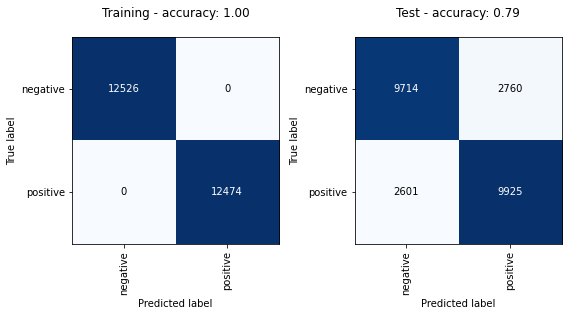

In [20]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

# 1D Convolutional Neural Network

In [21]:
n_kernels = 256
kernel_size = 3

n_dense = 256
dropout = 0.2

batch_size = 64
epochs = 10

In [22]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Conv1D(n_kernels, kernel_size, activation='relu', input_shape=(n_input_dim, n_embed_dim)))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 256)           98560     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 164,609
Trainable params: 164,609
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 9s 23ms/step - loss: 0.4045 - accuracy: 0.8126 - val_loss: 0.3542 - val_accuracy: 0.8439
Epoch 2/10
391/391 [==============================] - 7s 19ms/step - loss: 0.3071 - accuracy: 0.8678 - val_loss: 0.3798 - val_accuracy: 0.8320
Epoch 3/10
391/391 [==============================] - 7s 19ms/step - loss: 0.2567 - accuracy: 0.8931 - val_loss: 0.3427 - val_accuracy: 0.8554
Epoch 4/10
391/391 [==============================] - 8s 20ms/step - loss: 0.2124 - accuracy: 0.9155 - val_loss: 0.3538 - val_accuracy: 0.8556
Epoch 5/10
391/391 [==============================] - 8s 21ms/step - loss: 0.1515 - accuracy: 0.9448 - val_loss: 0.3823 - val_accuracy: 0.8511
Epoch 6/10
391/391 [==============================] - 9s 22ms/step - loss: 0.1053 - accuracy: 0.9627 - val_loss: 0.4242 - val_accuracy: 0.8528
Epoch 7/10
391/391 [==============================] - 8s 21ms/step - loss: 0.0634 - accuracy: 0.9795 - val_loss: 0.5743 - val_accuracy: 0.8355

In [25]:
x = featurize_w2v_dl(model_w2v, ['nice movie and i really liked the end'.split()], n_input_dim, n_embed_dim)
model.predict(x)

array([[1.]], dtype=float32)

In [26]:
x = featurize_w2v_dl(model_w2v, ['this was a waste of time a terrible movie'.split()], n_input_dim, n_embed_dim)
model.predict(x)

array([[5.956034e-11]], dtype=float32)

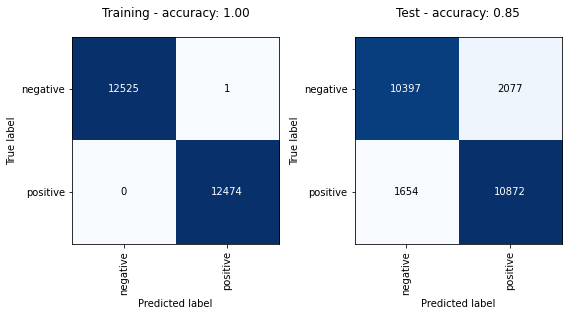

In [27]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

# Recurrent Neural Networks

## Simple RNN

In [28]:
# parameters
epochs = 10
batch_size = 128

n_rnn = 256
drop_rnn = 0.2

In [29]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()

model.add(SimpleRNN(n_rnn, dropout=drop_rnn, activation='relu', input_shape=(None, n_embed_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               98560     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 98,817
Trainable params: 98,817
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
196/196 [==============================] - 19s 96ms/step - loss: 0.6437 - accuracy: 0.6258 - val_loss: 0.6839 - val_accuracy: 0.5458
Epoch 2/10
196/196 [==============================] - 18s 93ms/step - loss: 0.8109 - accuracy: 0.5684 - val_loss: 0.6951 - val_accuracy: 0.5008
Epoch 3/10
196/196 [==============================] - 18s 92ms/step - loss: 0.7041 - accuracy: 0.5223 - val_loss: 0.6907 - val_accuracy: 0.5089
Epoch 4/10
196/196 [==============================] - 18s 93ms/step - loss: 0.6870 - accuracy: 0.5280 - val_loss: 0.6766 - val_accuracy: 0.5449
Epoch 5/10
196/196 [==============================] - 18s 94ms/step - loss: 0.7273 - accuracy: 0.5300 - val_loss: 0.6905 - val_accuracy: 0.5145
Epoch 6/10
196/196 [==============================] - 18s 93ms/step - loss: 0.6892 - accuracy: 0.5186 - val_loss: 0.6895 - val_accuracy: 0.5158
Epoch 7/10
196/196 [==============================] - 18s 92ms/step - loss: 0.6879 - accuracy: 0.5226 - val_loss: 0.6875 - val_accuracy:

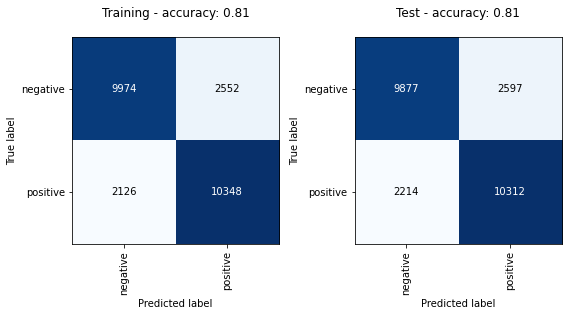

In [32]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

## Long Short Term Memory

In [33]:
# parameters
epochs = 10
batch_size = 128

n_lstm = 256
drop_lstm = 0.2

In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

model = Sequential()

model.add(LSTM(n_lstm, dropout=drop_lstm, activation='relu', input_shape=(None, n_embed_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])


In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 394,497
Trainable params: 394,497
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
196/196 [==============================] - 64s 329ms/step - loss: 0.6926 - accuracy: 0.5279 - val_loss: 0.6921 - val_accuracy: 0.5740
Epoch 2/10
196/196 [==============================] - 65s 331ms/step - loss: 0.6915 - accuracy: 0.5715 - val_loss: 0.6908 - val_accuracy: 0.5822
Epoch 3/10
196/196 [==============================] - 66s 335ms/step - loss: 0.6894 - accuracy: 0.5937 - val_loss: 0.6872 - val_accuracy: 0.6269
Epoch 4/10
196/196 [==============================] - 70s 358ms/step - loss: 2.1940 - accuracy: 0.6652 - val_loss: 0.6418 - val_accuracy: 0.7115
Epoch 5/10
196/196 [==============================] - 65s 332ms/step - loss: 0.6439 - accuracy: 0.7189 - val_loss: 0.6457 - val_accuracy: 0.7156
Epoch 6/10
196/196 [==============================] - 65s 330ms/step - loss: 0.6437 - accuracy: 0.7187 - val_loss: 0.6452 - val_accuracy: 0.7161
Epoch 7/10
196/196 [==============================] - 65s 333ms/step - loss: 0.6433 - accuracy: 0.7178 - val_loss: 0.6447 - val_ac

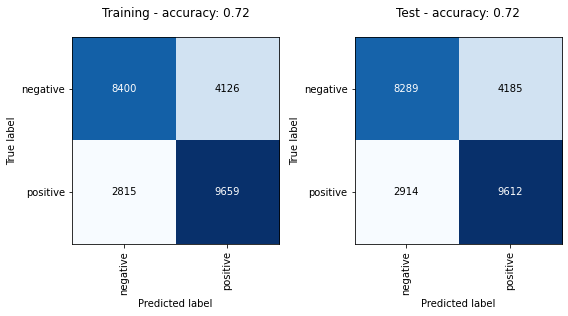

In [37]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

## Bidirectional LSTM

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers.wrappers import Bidirectional

model = Sequential()

model.add(Bidirectional(LSTM(n_rnn, dropout=drop_rnn, activation='relu'), input_shape=(None, n_embed_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512)               788480    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 788,993
Trainable params: 788,993
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
196/196 [==============================] - 141s 718ms/step - loss: 0.6921 - accuracy: 0.5396 - val_loss: 0.6911 - val_accuracy: 0.5751
Epoch 2/10
196/196 [==============================] - 145s 740ms/step - loss: 0.6903 - accuracy: 0.5853 - val_loss: 0.6891 - val_accuracy: 0.6038
Epoch 3/10
196/196 [==============================] - 145s 739ms/step - loss: 0.6870 - accuracy: 0.6070 - val_loss: 0.6834 - val_accuracy: 0.6237
Epoch 4/10
196/196 [==============================] - 143s 730ms/step - loss: 1.1165 - accuracy: 0.6472 - val_loss: 0.6467 - val_accuracy: 0.6610
Epoch 5/10
196/196 [==============================] - 143s 730ms/step - loss: 0.6436 - accuracy: 0.6584 - val_loss: 0.6426 - val_accuracy: 0.6660
Epoch 6/10
196/196 [==============================] - 144s 736ms/step - loss: 0.6373 - accuracy: 0.6644 - val_loss: 0.6342 - val_accuracy: 0.6764
Epoch 7/10
196/196 [==============================] - 144s 735ms/step - loss: 0.7112 - accuracy: 0.6924 - val_loss: 0.6319 -

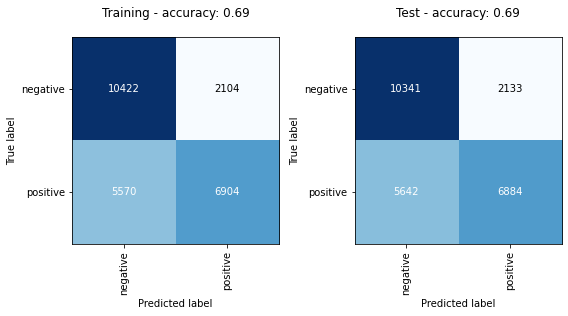

In [41]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])